In [170]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression , Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.preprocessing import StandardScaler , MinMaxScaler


In [171]:
source_path = r'../dataset\data.csv'
source_df = pd.read_csv(source_path)

display(source_df)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,3.130000e+05,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2.384000e+06,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,3.420000e+05,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,4.200000e+05,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,5.500000e+05,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,2014-07-09 00:00:00,3.081667e+05,3.0,1.75,1510,6360,1.0,0,0,4,1510,0,1954,1979,501 N 143rd St,Seattle,WA 98133,USA
4596,2014-07-09 00:00:00,5.343333e+05,3.0,2.50,1460,7573,2.0,0,0,3,1460,0,1983,2009,14855 SE 10th Pl,Bellevue,WA 98007,USA
4597,2014-07-09 00:00:00,4.169042e+05,3.0,2.50,3010,7014,2.0,0,0,3,3010,0,2009,0,759 Ilwaco Pl NE,Renton,WA 98059,USA
4598,2014-07-10 00:00:00,2.034000e+05,4.0,2.00,2090,6630,1.0,0,0,3,1070,1020,1974,0,5148 S Creston St,Seattle,WA 98178,USA


In [172]:
def perform_data_formatting(input_df):
    
    # converting datgetime to date format
    input_df['date'] = pd.to_datetime(input_df['date'])
    
    current_date = pd.Timestamp.now()
    
    # input_df['house_age_in_months'] = (current_date.year - input_df['date'].dt.year) * 12 + \
    #                   (current_date.month - input_df['date'].dt.month)

    # input_df['date'] = input_df['date'].dt.date
    
    # splitting state code and zip code into different columns
    input_df[['state', 'zipcode']] = input_df['statezip'].str.split(' ', expand=True)
    
    # dropping unwanted columns
    input_df = input_df.drop(['statezip', 'street','date'], axis=1)
    
    input_df['years_since_renovation'] = np.where(
        (input_df['yr_renovated'].isna()) | (input_df['yr_renovated'] == 0),
        2025 - input_df['yr_built'],
        2025 - input_df['yr_renovated']
    )


    input_df['years_since_built'] = 2025 - input_df['yr_built']
    
    input_df.drop(['yr_built','yr_renovated'], axis = 1, inplace = True)

    return input_df

formatted_df = perform_data_formatting(source_df)

In [173]:
formatted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price                   4600 non-null   float64
 1   bedrooms                4600 non-null   float64
 2   bathrooms               4600 non-null   float64
 3   sqft_living             4600 non-null   int64  
 4   sqft_lot                4600 non-null   int64  
 5   floors                  4600 non-null   float64
 6   waterfront              4600 non-null   int64  
 7   view                    4600 non-null   int64  
 8   condition               4600 non-null   int64  
 9   sqft_above              4600 non-null   int64  
 10  sqft_basement           4600 non-null   int64  
 11  city                    4600 non-null   object 
 12  country                 4600 non-null   object 
 13  state                   4600 non-null   object 
 14  zipcode                 4600 non-null   

In [174]:
formatted_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,years_since_renovation,years_since_built
count,4.600000e+03,4600.000000,4600.000000,4600.000000,4.600000e+03,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000
mean,5.519630e+05,3.400870,2.160815,2139.346957,1.485252e+04,1.512065,0.007174,0.240652,3.451739,1827.265435,312.081522,39.957391,54.213696
std,5.638347e+05,0.908848,0.783781,963.206916,3.588444e+04,0.538288,0.084404,0.778405,0.677230,862.168977,464.137228,26.863922,29.731848
min,0.000000e+00,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,11.000000,11.000000
25%,3.228750e+05,3.000000,1.750000,1460.000000,5.000750e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,20.000000,28.000000
50%,4.609435e+05,3.000000,2.250000,1980.000000,7.683000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,31.000000,49.000000
75%,6.549625e+05,4.000000,2.500000,2620.000000,1.100125e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,610.000000,52.000000,74.000000
max,2.659000e+07,9.000000,8.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,125.000000,125.000000


In [175]:
formatted_df = formatted_df[formatted_df['price'] != 0]

In [176]:
Q1 = formatted_df['price'].quantile(0.25)
Q3 = formatted_df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 0.8 * IQR
upper_bound = Q3 + 1.5 * IQR


outliers = formatted_df[(formatted_df['price'] < lower_bound) | (formatted_df['price'] > upper_bound)]
print(f'Q1 : {Q1}   , Q3 : {Q3}  , IQR : {IQR}')
print(f'lower_bound  :  {lower_bound}')
print(f'upper_bound  :  {upper_bound}')
print("Number of outliers:", outliers.shape[0])

formatted_df_clean = formatted_df[(formatted_df['price'] >= lower_bound) & (formatted_df['price'] <= upper_bound)]


Q1 : 326264.2857145   , Q3 : 657500.0  , IQR : 331235.7142855
lower_bound  :  61275.7142861
upper_bound  :  1154353.57142825
Number of outliers: 241


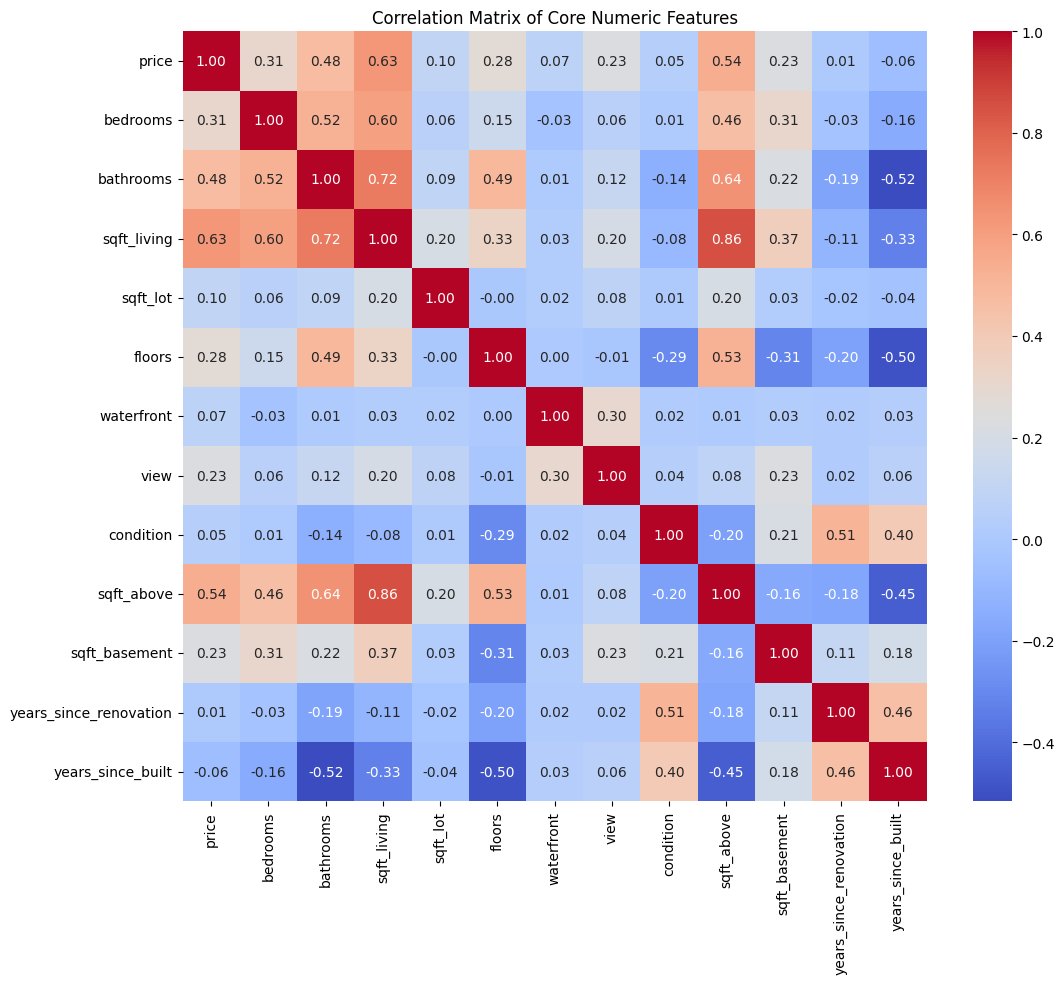

In [177]:
def identify_correlation(input_df):
    numeric_features = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
        'floors', 'waterfront', 'view', 'condition', 'sqft_above',
        'sqft_basement', 'years_since_renovation','years_since_built']

    numeric_df = input_df[numeric_features]

    # Calculate the correlation matrix
    corr_matrix = numeric_df.corr()

    # Set up the matplotlib figure
    plt.figure(figsize=(12, 10))

    # Draw the heatmap
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Core Numeric Features')
    plt.savefig('../visualizations/feature_correleation_heatmap.png', bbox_inches='tight')  # Adjust path as needed

    # plt.show()
    
identify_correlation(formatted_df_clean)

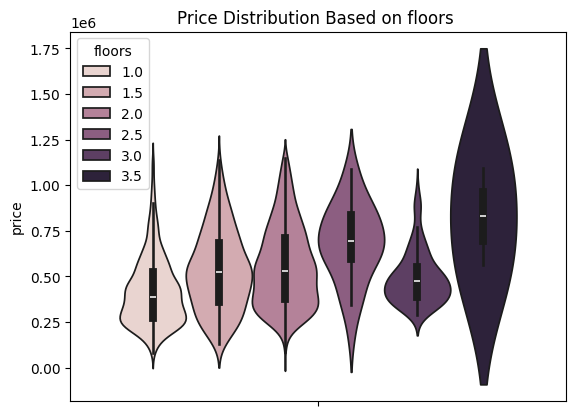

In [178]:
def display_violin_plot(input_df):
    sns.violinplot(data=input_df, y= 'price', hue = 'floors')
    plt.title('Price Distribution Based on floors ')
    plt.savefig('../visualizations/price_distribution_violinplot.png', bbox_inches='tight')  

display_violin_plot(formatted_df_clean)

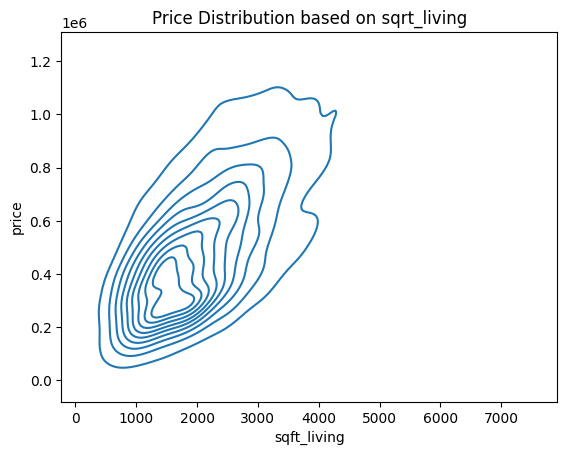

In [179]:
def display_kdeplot_sqrtliving(input_df):
    sns.kdeplot(data=formatted_df_clean, x= 'sqft_living', y='price')
    plt.title('Price Distribution based on sqrt_living')
    plt.savefig('../visualizations/price_sqrt_relation_kdeplot.png', bbox_inches='tight')  

display_kdeplot_sqrtliving(formatted_df_clean)

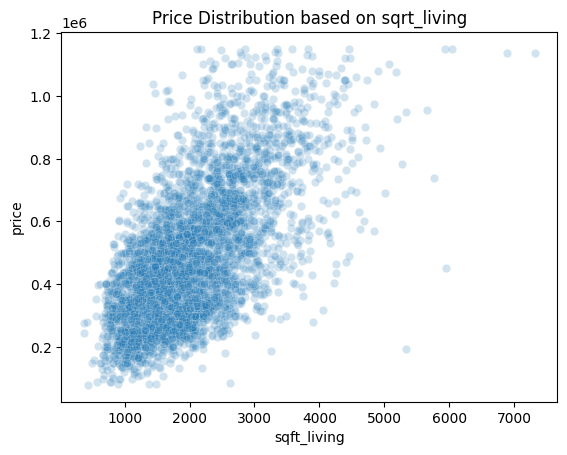

In [180]:
def display_scatterplot_sqrtliving(input_df):
    sns.scatterplot(data=formatted_df_clean, x= 'sqft_living', y='price',alpha=0.2 )    
    plt.title('Price Distribution based on sqrt_living')
    plt.savefig('../visualizations/price_sqrt_relation_scatterplot.png', bbox_inches='tight')  

display_scatterplot_sqrtliving(formatted_df_clean)

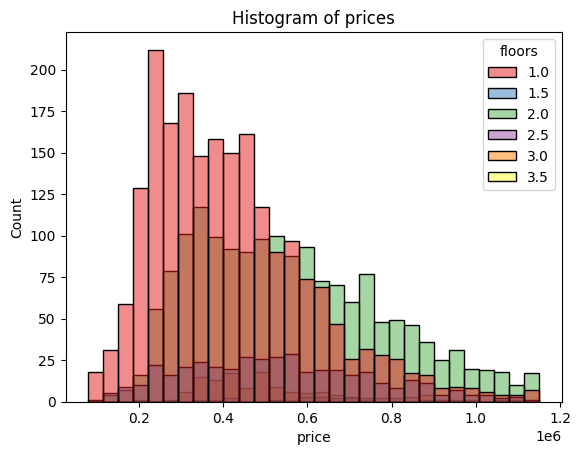

In [181]:
def display_histplot_price(input_df):
    sns.histplot(data= formatted_df_clean, x= 'price', hue= 'floors', palette='Set1')
    plt.title('Histogram of prices')
    plt.savefig('../visualizations/price_distribution_histplot.png', bbox_inches='tight')  

display_histplot_price(formatted_df_clean)

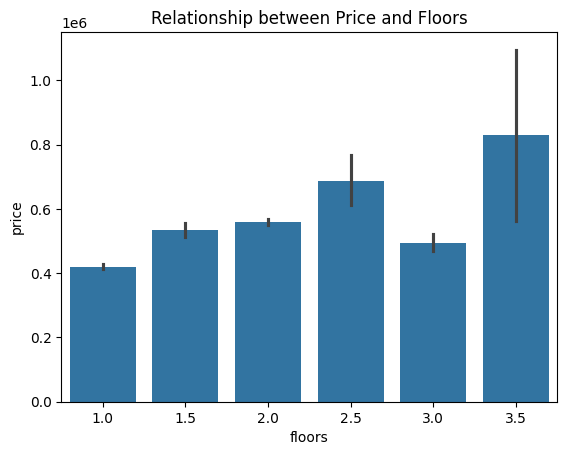

In [182]:
def display_barplot_floors(input_df):
    sns.barplot(data= formatted_df_clean, x= 'floors',y='price')
    plt.title('Relationship between Price and Floors')
    plt.savefig('../visualizations/price_floors_relation.png', bbox_inches='tight')  

display_barplot_floors(formatted_df_clean)

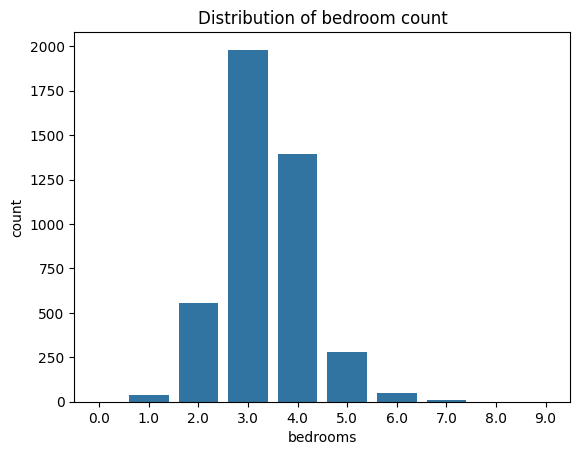

In [183]:
def display_barplot_bedrooms(input_df):
    sns.countplot(data= formatted_df_clean, x= 'bedrooms')
    plt.title('Distribution of bedroom count')
    plt.savefig('../visualizations/bedrooms_distribution.png', bbox_inches='tight')  

display_barplot_bedrooms(formatted_df_clean)

Index([3.0, 4.0, 2.0, 5.0, 6.0, 1.0, 7.0], dtype='float64', name='bedrooms')


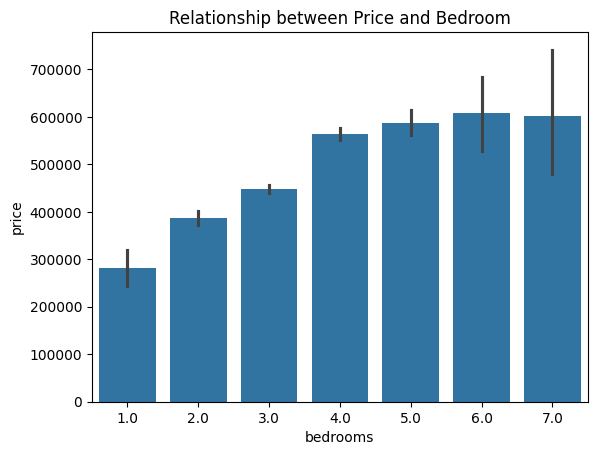

In [184]:
def display_bedroom_price_barplot(formatted_df_clean):
    bedroom_counts = formatted_df_clean['bedrooms'].value_counts()
    bedroom_to_keep = bedroom_counts[bedroom_counts >= 5].index

    print(bedroom_to_keep)
    bedroom_city = formatted_df_clean[formatted_df_clean['bedrooms'].isin(bedroom_to_keep)]

    sns.barplot(data= bedroom_city, x= 'bedrooms',y='price')
    plt.title('Relationship between Price and Bedroom')
    plt.savefig('../visualizations/price_bedrooms_relation.png', bbox_inches='tight')  
display_bedroom_price_barplot(formatted_df_clean)

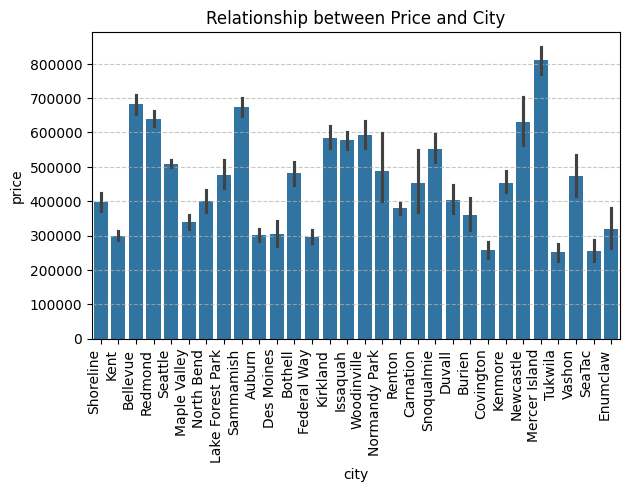

In [185]:
def display_city_price_relation_barplot(formatted_df_clean):
    city_counts = formatted_df_clean['city'].value_counts()
    cities_to_keep = city_counts[city_counts >= 10].index
    removed_city = formatted_df_clean[formatted_df_clean['city'].isin(cities_to_keep)]

    sns.barplot(data= removed_city, x= 'city',y='price')
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.title('Relationship between Price and City')
    plt.savefig('../visualizations/price_city_relation.png', bbox_inches='tight')  

display_city_price_relation_barplot(formatted_df_clean)

In [186]:
def apply_onhot_encoding(input_df):
# 3. One-hot encode 'city', 'country', 'state'
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_array = encoder.fit_transform(input_df[['city', 'country', 'state']])

    # 4. Create DataFrame with encoded columns
    encoded_cols = encoder.get_feature_names_out(['city', 'country', 'state'])
    encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=input_df.index)

    # 5. Drop original columns and concatenate encoded columns
    df_final = pd.concat([input_df.drop(['city', 'country', 'state'], axis=1), encoded_df], axis=1)
    return df_final

encoded_df = apply_onhot_encoding(formatted_df_clean)

In [187]:
target_column = 'price'
y = encoded_df[target_column]
X = encoded_df.drop(target_column, axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# You can now check the shape of your new datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3448, 59)
X_test shape: (862, 59)
y_train shape: (3448,)
y_test shape: (862,)


In [188]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on train, transform train
X_test_scaled = scaler.transform(X_test)  

In [189]:
metrics_list = []

In [190]:
def print_metrics(algorithm_name,y_test, y_pred):
    
    print(f'***** {algorithm_name} : Metrics ******')
    print()

    r2 = r2_score(y_test, y_pred)
    print(f"{algorithm_name} : R^2 score:", r2)

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{algorithm_name} : Mean Absolute Error (MAE):", mae)

    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{algorithm_name} : Mean Squared Error (MSE):", mse)
    
    rmse = np.sqrt(mse)
    print(f"{algorithm_name} : Root Mean Squared Error (RMSE):", rmse)
    
    metrics_dict = {"model": algorithm_name,
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,}
    
    metrics_list.append(metrics_dict)

In [191]:
def display_actual_pred_comparisions(algorithm_name,y_test,y_pred):
    
    a_title = algorithm_name + ' : Actual vs predicted values'

    sns.scatterplot(x=y_test, y= y_pred, alpha=0.25 )
    plt.title(a_title)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.grid()
    plt.savefig(f'../metrics/{algorithm_name}.png', bbox_inches='tight') 
    plt.show()

Model training complete.
***** Liner Regression : Metrics ******

Liner Regression : R^2 score: 0.6614367162651986
Liner Regression : Mean Absolute Error (MAE): 88173.57205552247
Liner Regression : Mean Squared Error (MSE): 16059705073.300571
Liner Regression : Root Mean Squared Error (RMSE): 126726.89167379026


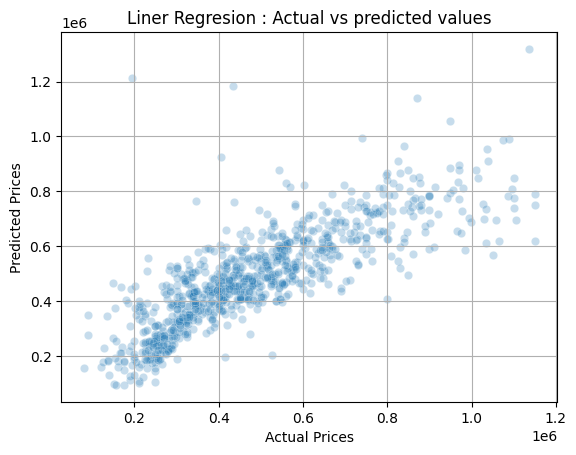

In [192]:
lr_model = LinearRegression()

lr_model.fit(X_train_scaled, y_train)
print("Model training complete.")

y_pred = lr_model.predict(X_test_scaled)

print_metrics('Liner Regression',y_test, y_pred)
display_actual_pred_comparisions('Liner Regresion',y_test, y_pred)

Model training complete.
***** Lasso Regression : Metrics ******

Lasso Regression : R^2 score: 0.6614371562077626
Lasso Regression : Mean Absolute Error (MAE): 88173.23103274127
Lasso Regression : Mean Squared Error (MSE): 16059684204.68261
Lasso Regression : Root Mean Squared Error (RMSE): 126726.80933678796


C:\Users\VimalS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.943e+12, tolerance: 1.593e+10
  model = cd_fast.enet_coordinate_descent(


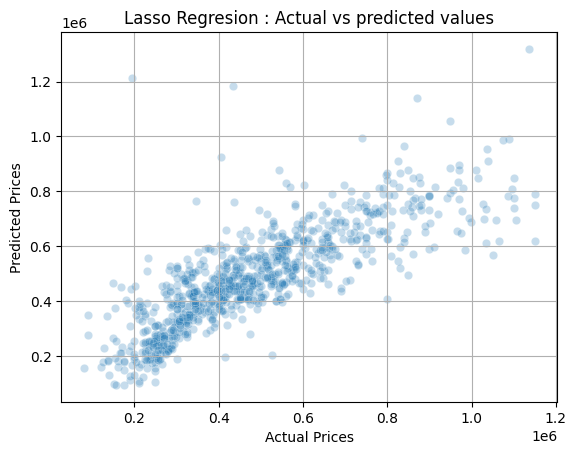

In [193]:
lasso  = Lasso(alpha=1.0)

lasso .fit(X_train_scaled, y_train)
print("Model training complete.")

y_pred = lasso.predict(X_test_scaled)

print_metrics('Lasso Regression',y_test, y_pred)
display_actual_pred_comparisions('Lasso Regresion',y_test, y_pred)

Model training complete.
***** Ridge Regression : Metrics ******

Ridge Regression : R^2 score: 0.6614517413900046
Ridge Regression : Mean Absolute Error (MAE): 88170.20642716753
Ridge Regression : Mean Squared Error (MSE): 16058992358.47098
Ridge Regression : Root Mean Squared Error (RMSE): 126724.0796315798


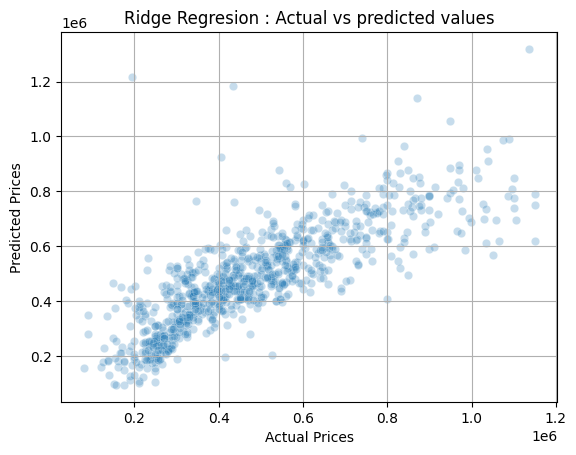

In [194]:
ridge  = Ridge(alpha=1.0)

ridge .fit(X_train_scaled, y_train)
print("Model training complete.")

y_pred = ridge.predict(X_test_scaled)

print_metrics('Ridge Regression',y_test, y_pred)
display_actual_pred_comparisions('Ridge Regresion',y_test, y_pred)

***** Random Forest Regression : Metrics ******

Random Forest Regression : R^2 score: 0.7101029550442646
Random Forest Regression : Mean Absolute Error (MAE): 79692.86943208997
Random Forest Regression : Mean Squared Error (MSE): 13751228403.305761
Random Forest Regression : Root Mean Squared Error (RMSE): 117265.63180789912


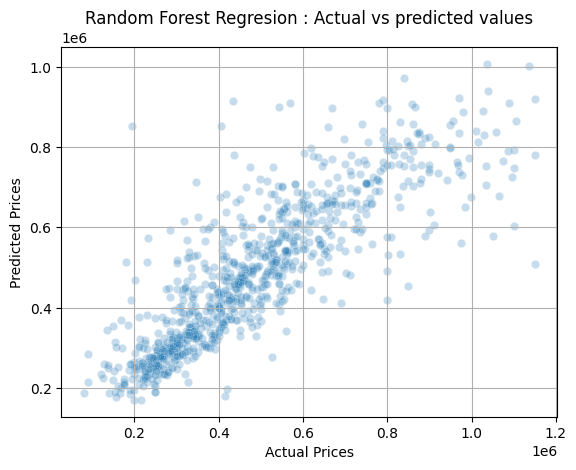

In [195]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=300, max_depth=20, random_state=42)
rf_model.fit(X_train_scaled, y_train)

y_pred = rf_model.predict(X_test_scaled)

print_metrics('Random Forest Regression',y_test, y_pred)
display_actual_pred_comparisions('Random Forest Regresion',y_test, y_pred)

In [196]:
import tensorflow as tf
from tensorflow import keras

In [197]:
model = keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


C:\Users\VimalS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [198]:
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 274430722048.0000 - mae: 479295.6250 - val_loss: 221892149248.0000 - val_mae: 425958.3438
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 65463881728.0000 - mae: 189053.4219 - val_loss: 21721606144.0000 - val_mae: 99357.2031
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16730675200.0000 - mae: 93220.4922 - val_loss: 19021967360.0000 - val_mae: 92911.4531
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15408152576.0000 - mae: 89234.6797 - val_loss: 17808807936.0000 - val_mae: 89930.0547
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14411334656.0000 - mae: 85619.4375 - val_loss: 17311590400.0000 - val_mae: 88209.6094
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13950110720.0000 - mae: 84128.5000 - val_loss: 16951665664.0000 - val_mae: 87133.7891
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13657519104.0000 - mae: 82907.6406 - val_loss: 16745497600.0000 - val_mae

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
***** ANN for Regression  : Metrics ******

ANN for Regression  : R^2 score: 0.6739071097161793
ANN for Regression  : Mean Absolute Error (MAE): 83240.44441522042
ANN for Regression  : Mean Squared Error (MSE): 15468173591.323217
ANN for Regression  : Root Mean Squared Error (RMSE): 124371.11236667146


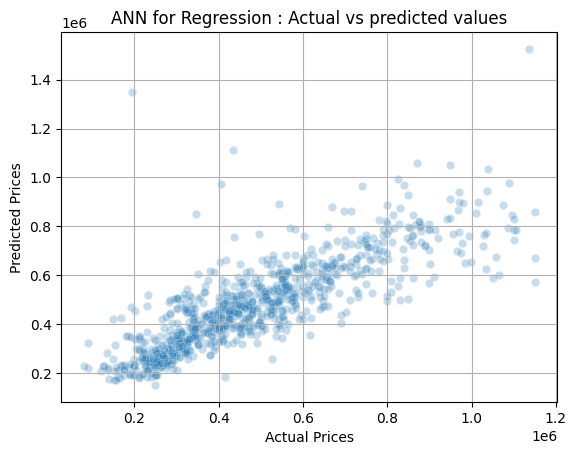

In [199]:
y_pred = model.predict(X_test_scaled).flatten()  # flatten to 1D array if needed

# Calculate R²
print_metrics('ANN for Regression ',y_test, y_pred)
display_actual_pred_comparisions('ANN for Regression',y_test, y_pred)

In [200]:
def display_metrics_comparision(metrics_df):
    plt.figure(figsize=(12,12))

    plt.subplot(2,2,1)
    sns.barplot(data= metrics_df, x= 'model',y ='r2')
    plt.xticks(rotation=45, ha='right')
    plt.title('R2 COMPARISION')
    plt.ylabel('R2 VALUE')

    plt.subplot(2,2,2)
    sns.barplot(data= metrics_df, x= 'model',y ='mae')
    plt.xticks(rotation=45, ha='right')
    plt.title('MAE COMPARISION')
    plt.ylabel('MAE VALUE')

    plt.subplot(2,2,3)
    sns.barplot(data= metrics_df, x= 'model',y ='mse')
    plt.xticks(rotation=45, ha='right')
    plt.title('MSE COMPARISION')
    plt.ylabel('MSE VALUE')

    plt.subplot(2,2,4)
    sns.barplot(data= metrics_df, x= 'model',y ='rmse')
    plt.xticks(rotation=45, ha='right')
    plt.title('RMSE COMPARISION')
    plt.ylabel('RMSE VALUE')

    plt.tight_layout()

    plt.savefig(f'../metrics/Metrics_comparision.png', bbox_inches='tight') 

,model,mse,rmse,mae,r2
0,Liner Regression,1.605971e+10,126726.891674,88173.572056,0.661437
1,Lasso Regression,1.605968e+10,126726.809337,88173.231033,0.661437
2,Ridge Regression,1.605899e+10,126724.079632,88170.206427,0.661452
3,Random Forest Regression,1.375123e+10,117265.631808,79692.869432,0.710103
4,ANN for Regression,1.546817e+10,124371.112367,83240.444415,0.673907


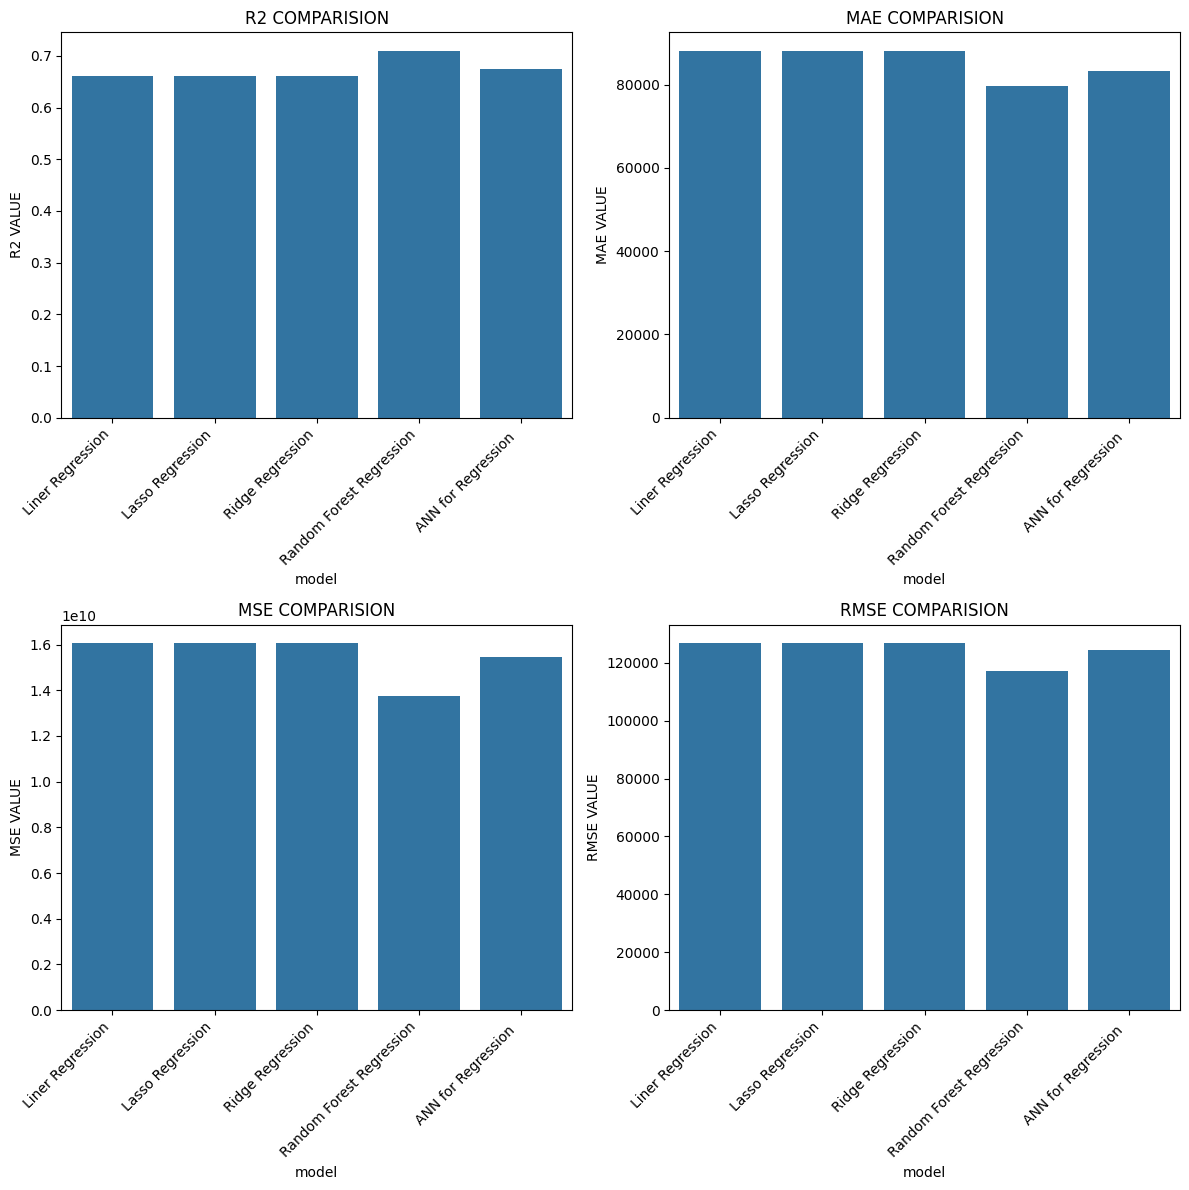

In [201]:

metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv("../metrics/model_metrics.csv", index=False)

display(metrics_df)

display_metrics_comparision(metrics_df)